In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import scipy 

import os
import copy
import random

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap 
from skimage.transform import rotate

import matplotlib.pyplot as plt

from skimage.transform import rotate
from shapely.geometry.polygon import Polygon
from argoverse.visualization.visualize_sequences import viz_sequence

from scipy.ndimage.interpolation import rotate

## Utils 

In [2]:
#---------------Vis-------------------
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'teal', 'skyblue',
                  'coral', 'darkorange', 'lime', 'darkorchid', 'saddlebrown', 'khaki', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 1], traj[:, 0], c='k', linestyle='dashed')
            #continue
        
        else:
            plt.plot(traj[:, 1], traj[:, 0], c=color_lst[cluster % len(color_lst)])
            
    plt.xlim([-60, 70])
    plt.ylim([-50, 110])
    plt.show()

In [3]:
#-------Hausdorff + DBSCAN------------------
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN

def hausdorff(u, v):
        d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
        return d    
    
def hausdorff_dist(traj_lst):
    traj_count = len(traj_lst)
    D = np.zeros((traj_count, traj_count))

    # This may take a while
    for i in range(traj_count):
        for j in range(i + 1, traj_count):
            distance = hausdorff(traj_lst[i], traj_lst[j])
            D[i, j] = distance
            D[j, i] = distance
    return D

def dbscan(D, eps=25, min_samples=8):
    mdl = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_lst = mdl.fit_predict(D)

    cluster_count = np.max(cluster_lst) + 1
    print(cluster_count)
    
    return cluster_lst

    #plot_cluster(traj_lst, cluster_lst)

## Cluster

In [4]:
avm = ArgoverseMap()

In [5]:
data_path = os.path.join('../LaneGCN/', "dataset","preprocess", "val_crs_dist6_angle90.p")
data_argo = np.load(data_path, allow_pickle=True)

In [6]:
##set root_dir to the correct path to your dataset folder
root_dir = '../LaneGCN/dataset/val/data/'
afl = ArgoverseForecastingLoader(root_dir)
afl.seq_list = sorted(afl.seq_list)

In [7]:
def get_confidence_flag(city, orig, final):
    flag_confidence = 1
    lane_dir1 = avm.get_lane_direction(query_xy_city_coords=orig, city_name=city, visualize=False)
    lane_dir2 = avm.get_lane_direction(query_xy_city_coords=final, city_name=city, visualize=False)
    if lane_dir1[-1] < 0.8 or lane_dir2[-1] < 0.8:
        flag_confidence = -1
    return flag_confidence


def get_lane_turn_flag(city, orig, final):
    lane_turn_flag = 1

    lane_turn_orig = avm.get_lane_turn_direction(avm.get_nearest_centerline(orig, city)[0].id, city)
    lane_turn_final = avm.get_lane_turn_direction(avm.get_nearest_centerline(final, city)[0].id, city)

    if lane_turn_final!='NONE' or lane_turn_orig!='NONE':
        lane_turn_flag = -1
    return lane_turn_flag
    
    
def get_lane_curve_flag(city, orig, final):
    lane_curv_flag = 1
    
    a = avm.get_nearest_centerline(orig, city)[0].centerline 
    dir_lane = a[-1] - a[0]
    lane_curv_orig = np.arctan2(dir_lane[-1], dir_lane[0])
    
    b = avm.get_nearest_centerline(final, city)[0].centerline
    dir_lane = b[-1] - b[0]
    lane_curv_final = np.arctan2(dir_lane[-1], dir_lane[0])
    
    if lane_curv_final * lane_curv_orig < 0:
        lane_curv_flag = -1
    else:
        if abs(lane_curv_final - lane_curv_orig) > 0.1:
            lane_curv_flag = -1
    return lane_curv_flag

In [8]:
trajs = []

for _ in range(20000):
    idx = np.random.randint(0, len(afl.seq_list), 1)[0]
    
    city = data_argo[idx]['city']
    orig = data_argo[idx]['orig']
    final = data_argo[idx]['gt_preds'][0][-1]
    
    traj = data_argo[idx]['gt_preds'][0]
    traj_norm = np.matmul(data_argo[idx]['rot'], (traj - data_argo[idx]['orig'].reshape(-1, 2)).T).T
    
    deg = np.rad2deg(np.arctan2(traj_norm[-1][-1], traj_norm[-1][0]))
    if abs(deg) > 90:
        traj_norm[:, 0] = - traj_norm[:, 0]
        traj_norm[:, 1] = - traj_norm[:, 1]
        
    sc1 = get_confidence_flag(city, orig, final)
    sc2 = get_lane_turn_flag(city, orig, final)
    sc3 = get_lane_curve_flag(city, orig, final)
    
    if sc1 == -1 or sc2 == -1 or sc3 == -1:
        trajs.append(traj_norm)
    else:
        if np.random.randint(0, 2) == 0:
            trajs.append(traj_norm)

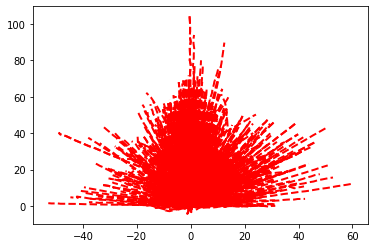

In [9]:
traj_lst = np.concatenate([trajs], 0)

for traj in traj_lst: 
    traj_p_x = traj[:, 1]
    traj_p_y = traj[:, 0]
    plt.plot(traj_p_x, traj_p_y, c='red', linestyle='dashed', linewidth=2)
plt.show()

## Intentions

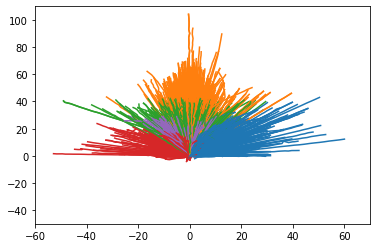

In [20]:
from copkmeans.cop_kmeans import cop_kmeans
cluster_lst, centers = cop_kmeans(dataset=traj_lst[:, -1], k=5)
plot_cluster(traj_lst, cluster_lst)

## Hierarchical clustering

In [27]:
deg = []
for traj in traj_lst:
    deg.append(np.rad2deg(np.arctan2(traj[-1][-1], traj[-1][0])))
deg = np.array(deg)

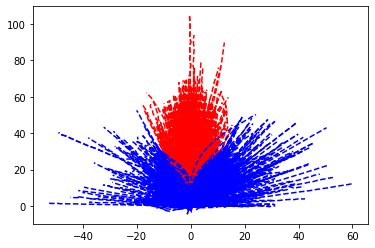

In [28]:
idx_deg = np.where(abs(deg)<20)
idx_turn = np.where((abs(deg)>20))

for traj in traj_lst[idx_deg]:
    traj_p_x = traj[:, 1]
    traj_p_y = traj[:, 0]
    plt.plot(traj_p_x, traj_p_y, c='red', linestyle='dashed')

for traj in traj_lst[idx_turn]: 
    traj_p_x = traj[:, 1]
    traj_p_y = traj[:, 0]
    plt.plot(traj_p_x, traj_p_y, c='blue', linestyle='dashed')

plt.show()

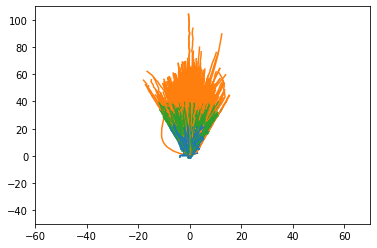

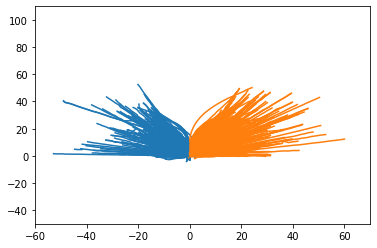

In [29]:
from copkmeans.cop_kmeans import cop_kmeans

cluster_lst1, centers1 = cop_kmeans(dataset=traj_lst[idx_deg][:, -1], k=3)
plot_cluster(traj_lst[idx_deg], cluster_lst1)

cluster_lst2, centers2 = cop_kmeans(dataset=traj_lst[idx_turn][:, -1], k=2)
plot_cluster(traj_lst[idx_turn], cluster_lst2)

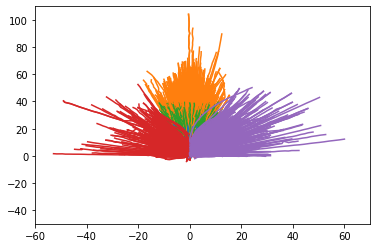

In [30]:
cluster_lst2 = np.array(cluster_lst2) + 3
plot_cluster(np.concatenate([traj_lst[idx_deg], traj_lst[idx_turn]], 0), 
             np.concatenate([cluster_lst1, cluster_lst2], 0))

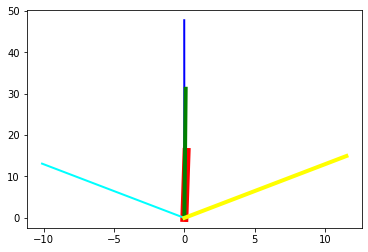

In [34]:
plt.plot([centers1[0][1], 0], [centers1[0][0], 0], 'r', linewidth=8)
plt.plot([centers1[1][1], 0], [centers1[1][0], 0], 'b', linewidth=2)
plt.plot([centers1[2][1], 0], [centers1[2][0], 0], 'g', linewidth=4)

plt.plot([centers2[0][1], 0], [centers2[0][0], 0], 'cyan', linewidth=2)
plt.plot([centers2[1][1], 0], [centers2[1][0], 0], 'yellow', linewidth=4)

## Save for testing new data

In [32]:
cluster_centers = np.zeros([5, 2]) 
cluster_centers[0] = centers1[2] #same
cluster_centers[1] = centers1[0] #slow
cluster_centers[2] = centers1[1] #fast

cluster_centers[3] = centers2[1] #left turn
cluster_centers[4] = centers2[0] #right turn

## Test new

In [33]:
intentions = ['straight-same', 
              'straight-slow', 
              'straight-fast', 
              'left-turn', 
              'right-turn', 
              'lane-change']

In [35]:
def get_intention(cluster_centers, traj_norm):
    tmp_idx = -1
    tmp_dist = 1000

    for i in range(5):
        dist = scipy.spatial.distance.cosine(cluster_centers[i], traj_norm[-1])
        if dist < tmp_dist:
            tmp_idx = i
            tmp_dist = dist

    idx_sel = -1
    dist_sel = 1000

    if tmp_idx < 3:
        city = data_argo[idx]['city']
        orig = data_argo[idx]['orig']
        final = data_argo[idx]['gt_preds'][0][-1]
        if get_confidence_flag(city, orig, final) == -1 and get_lane_turn_flag(city, orig, final)==1:
            idx_sel = 5
        else:
            for i in range(3):
                dist1 = np.linalg.norm(cluster_centers[i] - traj_norm[-1])
                if dist1 < dist_sel:
                    idx_sel = i
                    dist_sel = dist1
    else:
        for i in range(3, 5):
            dist1 = np.linalg.norm(cluster_centers[i] - traj_norm[-1])
            if dist1 < dist_sel:
                idx_sel = i
                dist_sel = dist1
    return idx_sel

7673


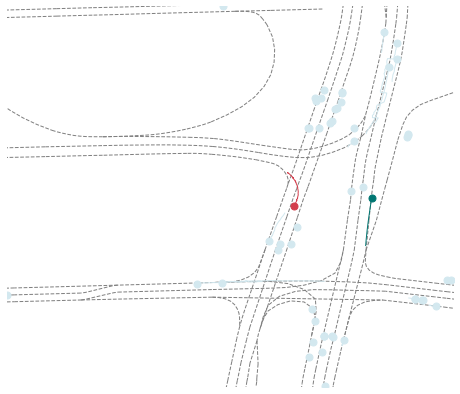

Intention:  right-turn
32857


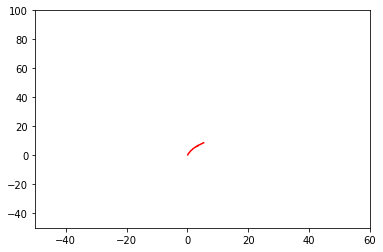

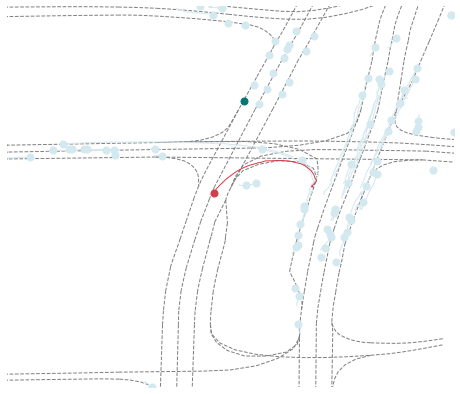

Intention:  left-turn
27498


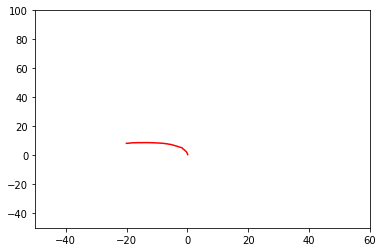

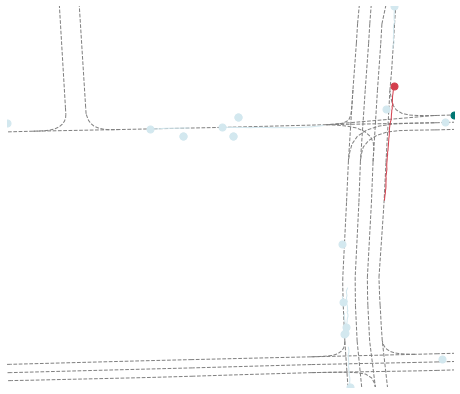

Intention:  straight-same
21897


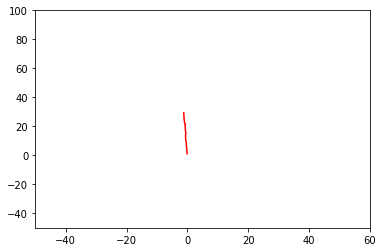

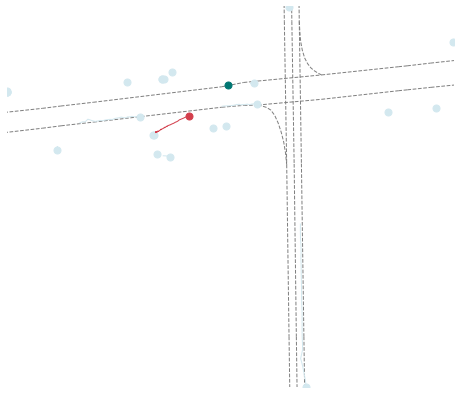

Intention:  lane-change
8538


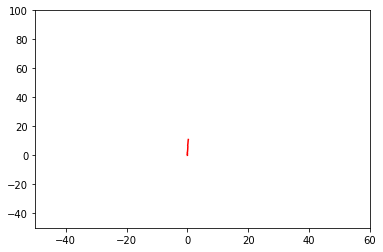

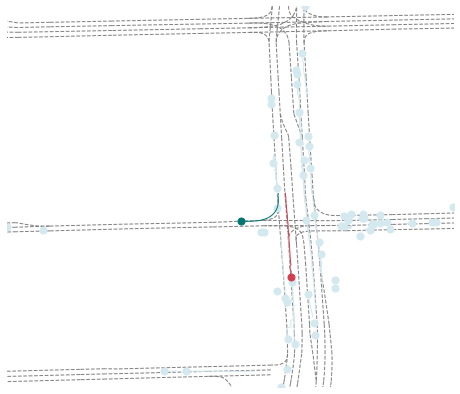

Intention:  straight-same
19978


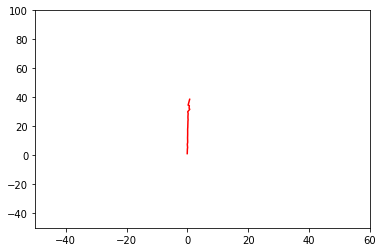

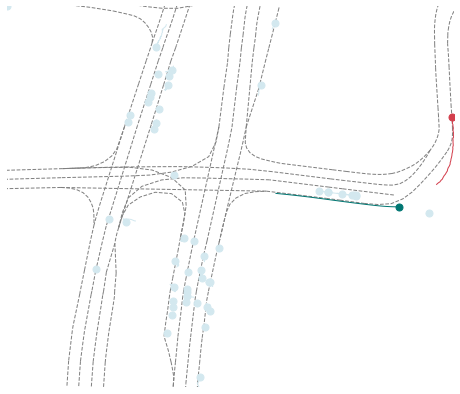

Intention:  straight-slow
31364


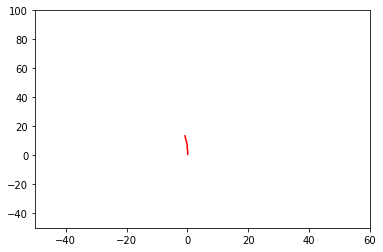

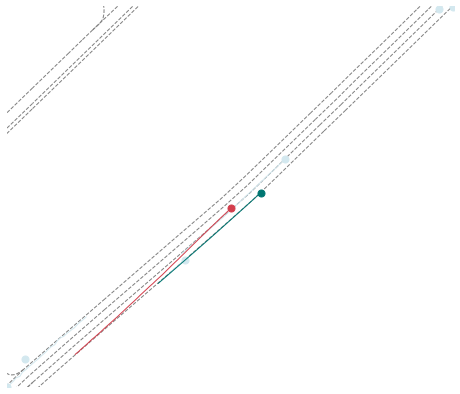

Intention:  lane-change
7650


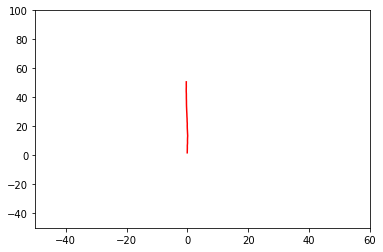

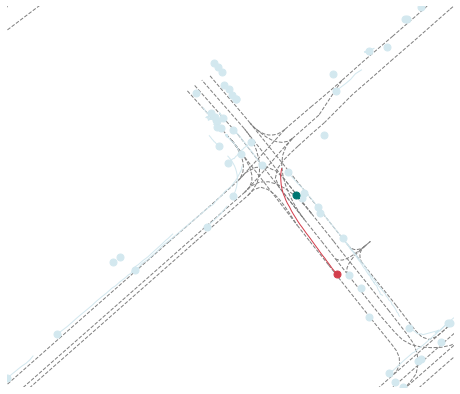

Intention:  straight-same
9667


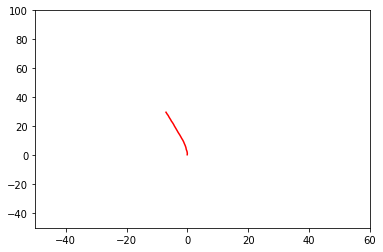

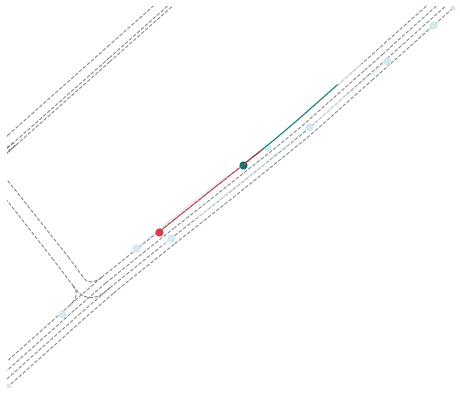

Intention:  straight-same
10204


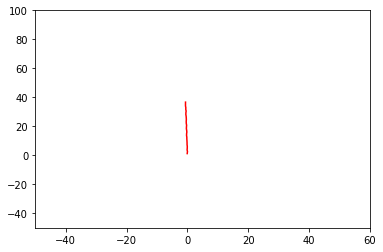

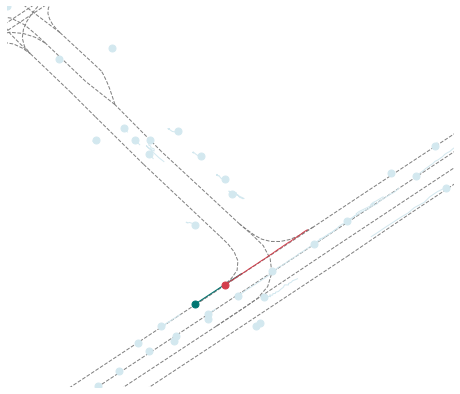

Intention:  straight-slow


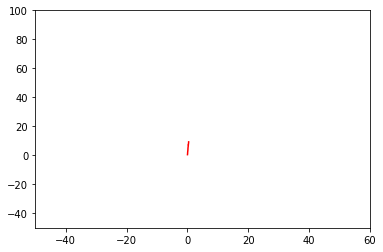

In [47]:
for _ in range(10):
    idx = np.random.randint(0, len(afl.seq_list), 1)[0]
    print(idx)
    traj = data_argo[idx]['gt_preds'][0]
    traj_norm = np.matmul(data_argo[idx]['rot'], (traj - data_argo[idx]['orig'].reshape(-1, 2)).T).T

    deg = np.rad2deg(np.arctan2(traj_norm[-1][-1], traj_norm[-1][0]))
    if abs(deg) > 90:
        traj_norm[:, 0] = - traj_norm[:, 0]
        traj_norm[:, 1] = - traj_norm[:, 1]
    intention_idx = get_intention(cluster_centers, traj_norm)

    seq_path = afl.seq_list[idx]
    viz_sequence(afl.get(seq_path).seq_df, show=True)
    print('Intention: ', intentions[intention_idx])

    plt.plot(-traj_norm[:, 1], traj_norm[:, 0], 'r')
    plt.xlim([-50, 60])
    plt.ylim([-50, 100])